# Purpose of the Notebook
This notebook demonstrates the use of Gromov-Wasserstein Optimal Transport (GWOT) for comparing two similarity structures.
It contains minimal but self-contained code snippets.
We utilize data on the similarity structures of 93 colors, evaluated on 8 levels by color-neurotypical participants, as used in our [paper](https://osf.io/preprints/psyarxiv/h3pqm).
For more advanced optimization techniques and additional example applications, please refer to our [toolbox](https://github.com/oizumi-lab/GWTune) on GitHub.

Author: Masafumi Oizumi

In [1]:
import os
import pickle as pkl
import sys
import numpy as np
import pandas as pd
import sklearn
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D

# if google colab is used, install pot
try:
    from google.colab import drive
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !git clone https://github.com/oizumi-lab/GWOT_tutorial.git
    !pip install pot

import ot

## Utility Functions

In [2]:
def add_colored_label(ax, x, y, bgcolor, width=1, height=1):
  rect = Rectangle((x, y), width, height, facecolor=bgcolor)
  ax.add_patch(rect)

def show_heatmaps(matrices, titles, cbar_label=None, color_labels=None):
  num_plots = len(matrices)
  fig, axs = plt.subplots(1, num_plots, figsize=(5*num_plots, 5))

  if num_plots == 1:
    axs = [axs]

  for i, (matrix, title) in enumerate(zip(matrices, titles)):
    ax = axs[i]
    im = ax.imshow(matrix, aspect='equal')
    ax.set_title(title)
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label(cbar_label)  # Set the legend of the color bar

    if color_labels is not None:
      ax.axis('off')
      for idx, color in enumerate(color_labels):
        add_colored_label(ax, -3.0, idx, color, width=3.0)
        add_colored_label(ax, idx, matrix.shape[0], color, height=3.0)

        ax.set_aspect('equal')
        ax.set_xlim(-3.0, matrix.shape[1])
        ax.set_ylim(matrix.shape[0] + 3.0, 0)

        for spine in ax.spines.values():
          spine.set_visible(False)


  plt.tight_layout()
  plt.show()

def plot_embeddings(embeddings, titles, color_labels, markers=['o', 'X'], overlay=False):
  if overlay:
    fig = plt.figure()
  else:
    num_plots = len(embeddings)
    fig = plt.figure(figsize=(5*num_plots, 5))

  if overlay:
      ax = fig.add_subplot(1, 1, 1, projection='3d')

  for i, embedding in enumerate(embeddings):
    if not overlay:
      ax = fig.add_subplot(1, num_plots, i+1, projection='3d')

    im = ax.scatter(
      xs = embedding[:, 0],
      ys = embedding[:, 1],
      zs = embedding[:, 2],
      marker = markers[i],
      color = color_labels,
      s = 20,
      alpha = 1,
      )

    if overlay:
      ax.scatter([], [], [], marker = markers[i], color = "black", s = 10, alpha = 1, label = titles[i])
      ax.legend(fontsize = 15, loc = "best")
    else:
      ax.set_title(titles[i])

  plt.show()

def RSA(matrix1, matrix2, method='pearson'):
  upper_tri_1 = matrix1[np.triu_indices(matrix1.shape[0], k=1)]
  upper_tri_2 = matrix2[np.triu_indices(matrix2.shape[0], k=1)]
  if method == 'pearson':
    corr, _ = pearsonr(upper_tri_1, upper_tri_2)
  elif method == 'spearman':
    corr, _ = spearmanr(upper_tri_1, upper_tri_2)

  return corr

def comp_matching_rate(OT_plan, k, order="maximum"):
  # This function computes the matching rate, assuming that in the optimal transportation plan,
  # the items in the i-th row and the j-th column are the same (correct mactch) when i = j.
  # Thus, the diagonal elements of the optimal transportation plan represent the probabilities
  # that the same items (colors) match between the two structures.

  # Get the diagonal elements
  diagonal = np.diag(OT_plan)
  # Get the top k values for each row
  if order == "maximum":
      topk_values = np.partition(OT_plan, -k)[:, -k:]
  elif order == "minimum":
      topk_values = np.partition(OT_plan, k - 1)[:, :k]
  # Count the number of rows where the diagonal is in the top k values and compute the matching rate
  count = np.sum([diagonal[i] in topk_values[i] for i in range(OT_plan.shape[0])])
  matching_rate = count / OT_plan.shape[0] * 100
  return matching_rate

## Load Data

In [3]:
if IN_COLAB:
    drive.mount('/content/drive')
    folder_path = '/content/GWOT_tutorial/data/color_data'
else:
    # set the path to the directory where the data is stored
    folder_path = '../data/color_data'

# Load two dissimilarity matrices of 93 colors, which are averaged over two non-overlapping color-neurotypical participants
RDM1 = np.load(os.path.join(folder_path, 'matrices/RDM_neutyp_group1.npy'))
RDM2 = np.load(os.path.join(folder_path, 'matrices/RDM_neutyp_group2.npy'))

# Load color labels
color_labels = np.load(os.path.join(folder_path, 'color_label/new_color_order.npy'))

FileNotFoundError: [Errno 2] No such file or directory: '../data/color_data/matrices/RDM_neutyp_group1.npy'

In [ ]:
RDM1

array([[0.33333333, 2.28571429, 2.33333333, ..., 5.54166667, 4.25      ,
        5.25      ],
       [2.28571429, 1.64285714, 0.83333333, ..., 6.16666667, 4.61111111,
        6.21428571],
       [2.33333333, 0.83333333, 0.8125    , ..., 4.77272727, 6.25      ,
        5.4       ],
       ...,
       [5.54166667, 6.16666667, 4.77272727, ..., 0.14285714, 1.4       ,
        1.77272727],
       [4.25      , 4.61111111, 6.25      , ..., 1.4       , 0.        ,
        1.25      ],
       [5.25      , 6.21428571, 5.4       , ..., 1.77272727, 1.25      ,
        0.125     ]])

In [ ]:
color_labels

array(['#E088A1', '#C4577A', '#B06079', '#9C1C53', '#7C3D4E', '#7D0B45',
       '#52253C', '#B28AB7', '#8F5AA8', '#8B5F92', '#642B7C', '#5D4263',
       '#430F59', '#331F3B', '#9796C0', '#7171C9', '#716B92', '#39319E',
       '#4E486C', '#261D6E', '#171639', '#86A2C9', '#427AC4', '#5F7AA7',
       '#0C4FA2', '#3F597A', '#022C88', '#032040', '#73B7C3', '#3394B7',
       '#5891A2', '#02529A', '#2F2874', '#03406F', '#09384C', '#8DCFC1',
       '#41A79A', '#68A899', '#086E79', '#367467', '#034E49', '#0A3B38',
       '#A3E2AC', '#5FC16E', '#83B37F', '#40A144', '#487F55', '#207427',
       '#163D1F', '#D8E26A', '#C5DD24', '#AEBE5A', '#AAC901', '#84932A',
       '#758E00', '#445507', '#FBEC77', '#FCDD2A', '#D3BE51', '#F4D000',
       '#AF972D', '#AA8F02', '#685A14', '#FAC88D', '#FBA628', '#E49A5B',
       '#FF8F00', '#AE783C', '#AC6401', '#76450B', '#FAAF99', '#FB702E',
       '#E67E72', '#E83406', '#A25739', '#A51A01', '#782918', '#F699A1',
       '#E26164', '#D2797D', '#DA0B27', '#96484B', 

# 1. Basic Analysis

## Visualization of Color Dissimilarity Matrices
First, let's visualize the color dissimilarity matrices, RDM1 and RDM2.
Note that with a 8-level rating where 0 is very similar and 7 is very dissimilar, higher similarity corresponds to lower values, and lower similarity corresponds to higher values. These are called Representational Dissimilarity Matrices (RDM).
Although there is no overlap in participants between the groups, the data is averaged from a considerable number of participants (about 200), so visually, they appear quite similar. Colors are displayed alongside the matrices, visually indicating which row and column correspond to which color.

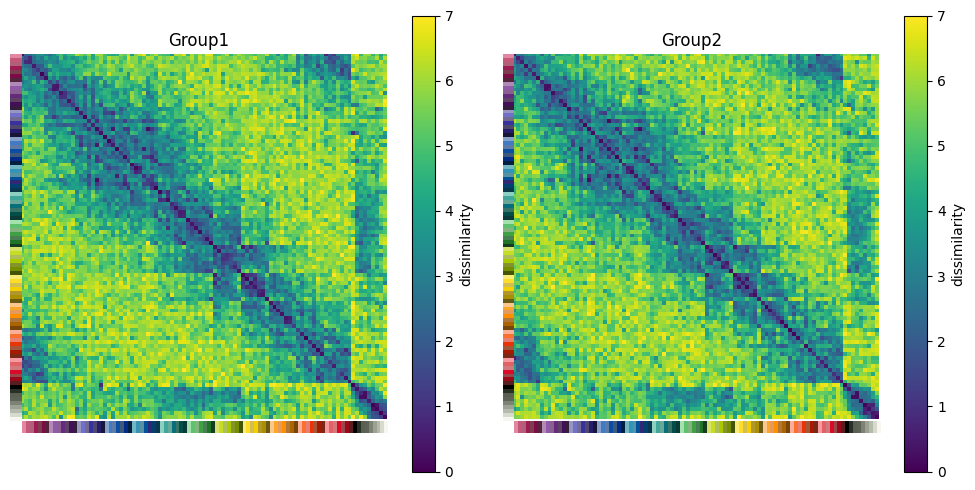

In [ ]:
show_heatmaps(matrices=[RDM1, RDM2], titles=['Group1', 'Group2'], cbar_label="dissimilarity", color_labels=color_labels)

## Visualization of Color Dissimilarity Relationships in Low-Dimensional Space
Next, let's visualize dissimilarity relationships between colors in 3D space by using Multi-Dimensional Scaling (MDS).

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


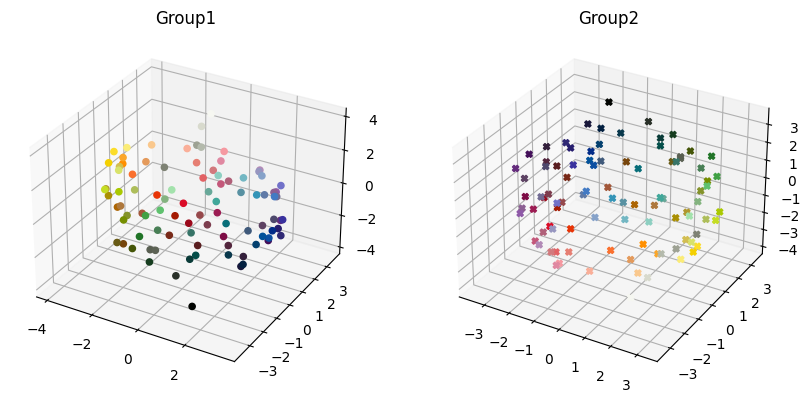

In [ ]:
embeddings = []
for RDM in [RDM1, RDM2]:
  mds = sklearn.manifold.MDS(n_components=3, dissimilarity='precomputed', random_state=5)
  embedding = mds.fit_transform(RDM)
  embeddings.append(embedding)

plot_embeddings(embeddings=embeddings, titles=['Group1', 'Group2'], color_labels=color_labels, overlay=False)

## Representational Similarity Analysis: Correlation between Dissmilarity Matrices
Visually, it is apparent that the similarity matrices of Group 1 and Group 2 are similar, but to quantitatively measure how similar they are, one method is to use the correlation coefficient. This involves calculating the correlation coefficient for all elements of the two similarity matrices. (More precisely, not all elements are considered, but the diagonal elements and the lower triangular part are excluded. The diagonal elements, which represent the similarity of the same items, are by definition always zero, so they are excluded. Also, since the similarity matrix is typically symmetric, the lower and upper triangular parts are the same, so one of them is excluded.) This method is called Representational Similarity Analysis (RSA) and is widely used in the field of neuroscience.

In [ ]:
RSA_corr = RSA(RDM1, RDM2)
print('RSA correlation coefficient : ', RSA_corr)

RSA correlation coefficient :  0.8338971447765334


# 2. Gromov-Wasserstein Optimal Transport (GWOT)

Gromov-Wasserstein Optimal Transport (GWOT) is a technique used to identify correspondences between two sets of points (referred to as "structures") and to quantify the degree of similarity between these structures. In the case of the 93 color similarity structure, there are 93 points in each point cloud, where each point represents a color. GWOT attempts to find the optimal transportation plan between these point clouds using only the internal relational information of each structure. The figure above, generated by Multi-Dimensional Scaling (MDS), illustrates the color similarity relationships as point clouds for both Group 1 and Group 2 participants. The purpose of using GWOT is to determine which points (which colors) in Group 1 should be transported to which points (which colors) in Group 2. The amount of mass transported represents the degree of correspondence (or the probability of correspondence) between the points in Group 1 and Group 2. Note that the transportation is generally many-to-many, rather than one-to-one. The degree of similarity between the two structures is then quantified by the minimized transportation cost, known as the Gromov-Wasserstein distance.

## 2.1 Entropic GWOT

Mathematically, Gromov-Wasserstein Optimal Transport is a problem of finding the optimal transportation plan $\Gamma$ that minimizes the Gromov-Wasserstein Distance given by the following equation:
$$
\text{GWD}= \min_{\Gamma}\sum_{i,j,k,l} (D_{i,k} - D'_{j,l})^2 \Gamma_{i,k}\Gamma_{j,l} \tag{1}
$$

- $D, D'$: Distance matrices
- $\Gamma$: Transportation plan

In practice, an additional term, entropy $H(\Gamma)$, is added to this GWD to minimize it. Adding the entropy term is known to reduce computational complexity and improve the optimization performance. (For more details, refer to the [documentation](https://pythonot.github.io/gen_modules/ot.gromov.html#ot.gromov.entropic_gromov_wasserstein)).

$$
\text{GWD}_{\epsilon}=\arg\min_{\Gamma}\sum_{i,j,k,l} (D_{i,k} - D'_{j,l})^2 \Gamma_{i,k}\Gamma_{j,l}+\epsilon H(\Gamma) \tag{2}
$$

The optimization problem to minimize the above equation is called entropic GWOT. In practice, to find good optimums, it is necessarly to properly adjust a hyperparameter $\epsilon$. This adjustment is known as hyperparameter tuning and it is important to perform it effectively to find good optimums.

Before performing hyperparameter tuning, first, let's start by setting $\epsilon$ to an appropriate value and perform entropic GWOT.

In [ ]:
epsilon = 0.2 # set the value of hyperparameter
# find the optimal transportation plan
OT_plan = ot.gromov.entropic_gromov_wasserstein(C1=RDM1,C2=RDM2,epsilon=epsilon,loss_fun="square_loss",verbose=True)

It.  |Err         
-------------------
    0|1.078511e-02|


/usr/local/lib/python3.10/dist-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


   10|7.055613e-05|
   20|3.557721e-08|
   30|4.125589e-11|


### Optimal Transportation Plan
The optimal transportation plan (OT_plan) obtained above is in the form of a 93 x 93 matrix, referred to as the optimal transportation matrix. The $(i, j)$ element of this matrix represents the "probability" (or something similar) that the i-th color in Group 1 corresponds to the j-th color in Group 2. Since the order of colors is the same in both Group 1 and Group 2, a large value in the diagonal elements ($i=j$) indicates that the same color corresponds to the same color. Visualizing the actual optimal transportation matrix shows that the diagonal elements are indeed large. In fact, not only the diagonal elements but also the elements slightly off the diagonal are large. This indicates that colors in Group 1 are transported to similar colors in Group 2, which is a reasonable result.

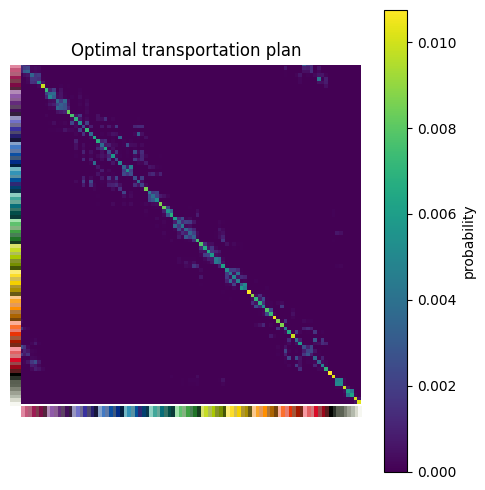

In [ ]:
show_heatmaps(matrices=[OT_plan], titles=['Optimal transportation plan'], cbar_label="probability", color_labels=color_labels)

### Varying the Value of $\epsilon$

Next, let's examine how the optimal transportation plan changes when the value of the entropy term coefficient $\epsilon$ is varied. Generally, as the value of $\epsilon$ increases, the transportation plan shifts from one-to-one mapping to many-to-many mapping. Additionally, for certain ranges of $\epsilon$, the large elements that were previously aligned along the diagonal may no longer be visible. Let's observe these changes.

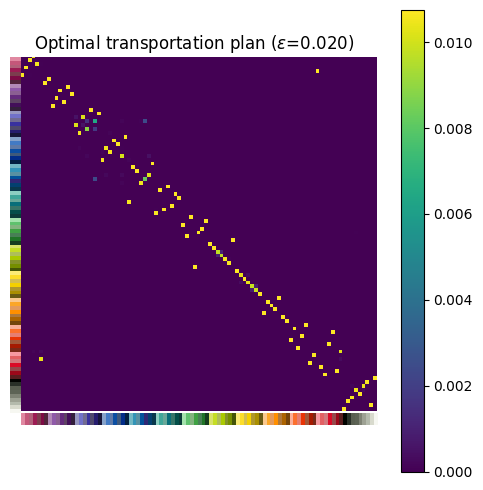

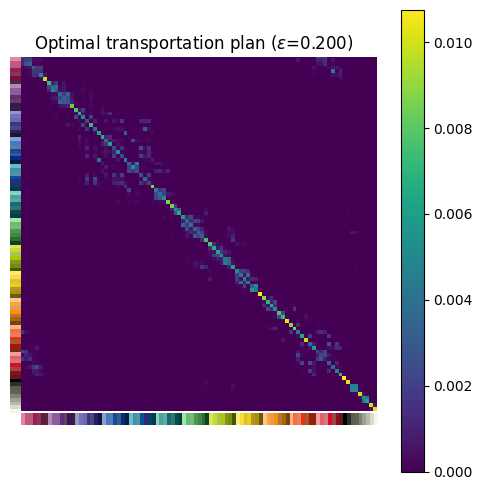

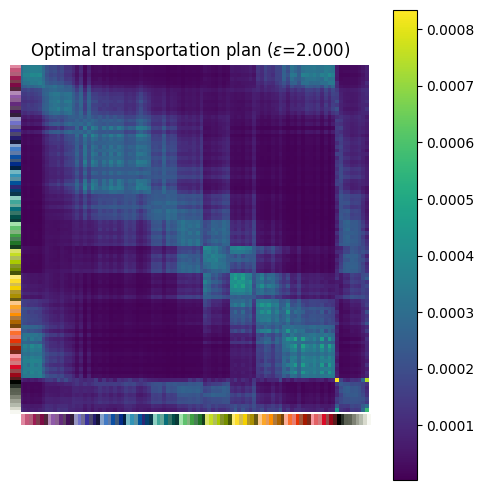

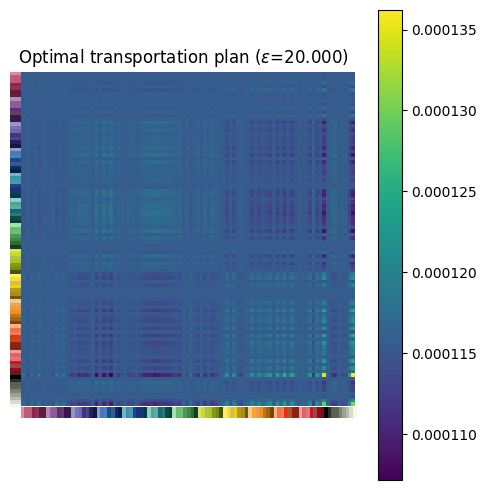

In [ ]:
# set the ranges of epsilon
epsilons = [0.02, 0.2, 2.0, 20.0]

# visualize optimal transportation plans depending on epsilon
for epsilon in epsilons:
  OT_plan = ot.gromov.entropic_gromov_wasserstein(C1=RDM1,C2=RDM2,epsilon=epsilon,loss_fun="square_loss",verbose=False)
  show_heatmaps(matrices=[OT_plan], titles=[f'Optimal transportation plan ($\epsilon$={epsilon:.3f})'], color_labels=color_labels)

## 2.2 Hyperparameter Tuning
For hyperparameter tuning of $\epsilon$, we need to run entropic GWOT for different values of $\epsilon$. Among the local optima found for different $\epsilon$ values, we select the transportation plan that minimizes the Gromov-Wasserstein distance without the entropy-regularization term (Eq. (1)).

In the for loop below, we search for different $\epsilon$ values, obtaining the optimal transportation plan and the Gromov-Wasserstein Distance (GWD). We also compute the matching rate, which evaluates the percentage of same colors matching between the two groups. Note, however, that the matching rate is not the optimization target in this process. We use only the GWD to select the best hyperparameter. This is a strictly "unsupervised" alignment procedure where only internal relationships are used, and external labels such as colors are not used for the alignment.

In [ ]:
### configuration
n_eps = 10 # number of epsilon values tried
eps_range = [0.02, 1] # the range of epsilon searched
epsilons = np.logspace(np.log10(eps_range[0]), np.log10(eps_range[1]), n_eps) # epsilon values

OT_plans = []
gwds = []
matching_rates = []

for epsilon in epsilons:
  print('*********************************')
  print(f'epsilon = {epsilon}')

  OT, gw_log = ot.gromov.entropic_gromov_wasserstein(C1=RDM1,C2=RDM2,epsilon=epsilon,loss_fun="square_loss", log=True)  # optimization
  gwd = gw_log['gw_dist']
  matching_rate = comp_matching_rate(OT, k=1)  # calculate the top 1 matching rate
  print(f'Gromov-Wasserstein distance : {gwd}, Matching rate : {matching_rate}')

  OT_plans.append(OT)
  gwds.append(gwd)
  matching_rates.append(matching_rate)

*********************************
epsilon = 0.020000000000000004
Gromov-Wasserstein distance : 0.7886258296338298, Matching rate : 33.33333333333333
*********************************
epsilon = 0.030889042098927583
Gromov-Wasserstein distance : 0.7812647822985395, Matching rate : 35.483870967741936
*********************************
epsilon = 0.04770664608946602
Gromov-Wasserstein distance : 0.5783786547390691, Matching rate : 81.72043010752688
*********************************
epsilon = 0.07368062997280773
Gromov-Wasserstein distance : 0.5900693515136026, Matching rate : 80.64516129032258
*********************************
epsilon = 0.11379620405527817
Gromov-Wasserstein distance : 0.6179268071568591, Matching rate : 81.72043010752688
*********************************
epsilon = 0.17575278688808205
Gromov-Wasserstein distance : 0.6771540262528171, Matching rate : 84.94623655913979
*********************************
epsilon = 0.2714417616594907
Gromov-Wasserstein distance : 0.79029080600898

### GWD values depending on epsilon values
Here, we plot the GWD values found for different $\epsilon$ values. In the figure, we can observe that the matching rate tends to be higher for local optima with lower GWD values. In such cases, we can achieve correct alignment between the two structures by selecting the one with the lowest GWD as the global optimum, i.e., by a purely unsupervised alignment procedure. However, note that this is not always the case.

As we can see in the figure, GWD is minimized when $\epsilon=0.0477$, and it is lower than the case where $\epsilon$ is lower. This may be counter-intuitive considering that in entropic GWOT, what is minimized is GWD plus the entropy term (Eq. (2)), not GWD itself (Eq. (1)). The entropy term can be regarded as an obstacle that prevents GWD from being minimized. However, what we observe here is that adding the entropy term with a moderate and appropriate value of $\epsilon$ practically helps to minimize GWD itself.

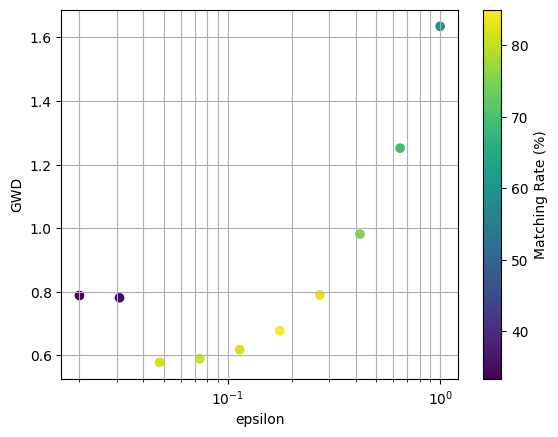

In [ ]:
plt.figure()
plt.scatter(epsilons, gwds, c=matching_rates)
plt.xlabel("epsilon")
plt.ylabel("GWD")
plt.xscale('log')
plt.grid(True, which = 'both')
cbar = plt.colorbar()
cbar.set_label(label='Matching Rate (%)')
plt.show()

### Visualize the optimal transportation plan where gwd is minimized
Finally, among the local optimums found for different $\epsilon$ values, let's select the optimal transportation plan that minize GWD and then, visualize the best optimal transportation plan.

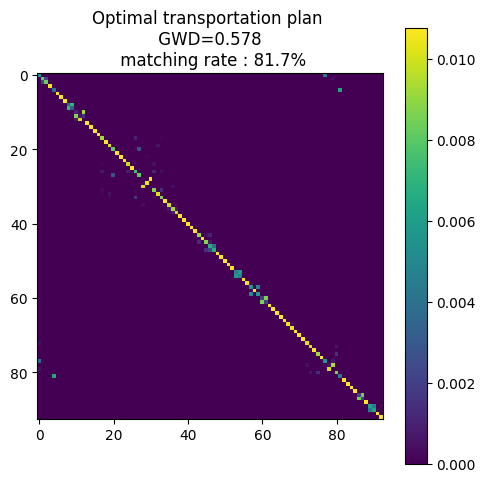

In [ ]:
# extract the best epsilon that minimizes the GWD
min_gwd = min(gwds)
best_eps_idx = gwds.index(min_gwd)
best_eps = epsilons[best_eps_idx]
OT_plan = OT_plans[best_eps_idx]
matching_rate = matching_rates[best_eps_idx]

show_heatmaps(
    matrices=[OT_plan],
    titles=[f'Optimal transportation plan \n GWD={min_gwd:.3f} \n matching rate : {matching_rate:.1f}%'])

## 2.3 Visualize the Aligned Embeddings
The optimal transportation plan provides the mapping of embeddings in one domain $X$ to the other domain $Y$. With the optimal transportation plan $\Gamma$, the embeddings in one domain $\mathbf{x}_i$ are mapped to the embeddings of the other domain $\mathbf{y}_j$ by the following function $F$,
$$
F(\mathbf{x}_i) = \sum^n_{j=1} \Gamma_{ij} \mathbf{y}_j
$$
With this mapping $F$, the embeddings $\mathbf{x}_i$, which are now represented by the linear combination of $\mathbf{y}_j$, are projected into the space of the other domain, where $\mathbf{y}_j$ resides. This is called barycentric projection. With this projection, the embeddings $\mathbf{x}_i$ and $\mathbf{y}_i$, which were previously not in the same space and thus not directly comparable, are now comparable within the same space. Here, we visualize the embeddings $\mathbf{y}_i$ and the aligned embeddings $F(\mathbf{x}_j)$.

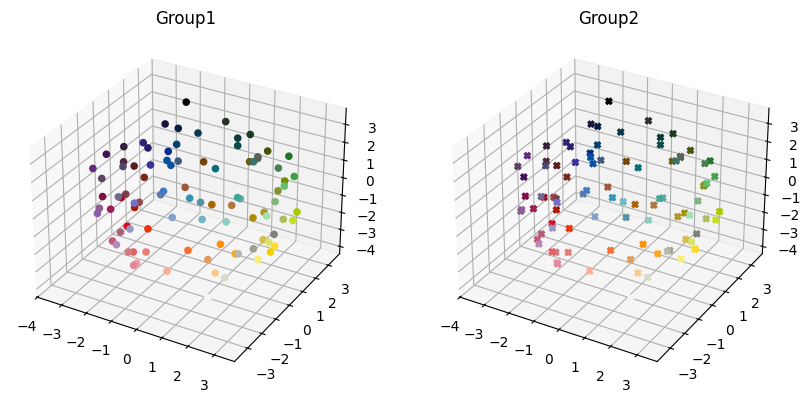

In [ ]:
embeddings_y = embeddings[1]
# barycentric projection of embedding2 to the space of embedding1
projected_embeddings_x = OT_plan @ embeddings_y * len(OT_plan)

plot_embeddings(
    embeddings=[embeddings_y, projected_embeddings_x],
    titles=['Group1', 'Group2'],
    overlay=False,
    color_labels=color_labels)